In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline


import sys
sys.path.append('/usr/local/lib/python2.7/site-packages/')

import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import operator
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import preprocessing
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
import csv

In [3]:
#running on a windows machine, change filepaths as needed

train_df = pd.read_csv('Data/train.csv')

In [4]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
print "Number of categories: {}".format(len(train_df.Category.unique()))
print "Summary of X"
print train_df.X.describe()
print "Summary of Y"
print train_df.Y.describe()

Number of categories: 39
Summary of X
count    878049.000000
mean       -122.422616
std           0.030354
min        -122.513642
25%        -122.432952
50%        -122.416420
75%        -122.406959
max        -120.500000
Name: X, dtype: float64
Summary of Y
count    878049.000000
mean         37.771020
std           0.456893
min          37.707879
25%          37.752427
50%          37.775421
75%          37.784369
max          90.000000
Name: Y, dtype: float64


In [5]:
# Feature Names: address, dayofweek
le = preprocessing.LabelEncoder()
dow = le.fit_transform(train_df.DayOfWeek.values)
dow_orig = le.classes_
addr = le.fit_transform(train_df.Address)
addr_orig = le.classes_
category = le.fit_transform(train_df.Category)
cat_orig = le.classes_
pdist = le.fit_transform(train_df.PdDistrict)
pd_orig = le.classes_

In [6]:
train_df['crime'] = category
train_df['addr'] = addr
train_df['dow'] = dow
train_df['pd'] = pdist

In [7]:
dates = pd.DatetimeIndex(train_df.Dates)

In [29]:
train_df['date'] = dates.date
train_df['time'] = dates.time
train_df['hour'] = dates.hour
train_df['minutes'] = dates.minute

train_df.ix[train_df.hour <12,'time_of_day'] = "morning"
train_df.ix[train_df.hour >=12,'time_of_day'] = "midday"
train_df.ix[train_df.hour >14,'time_of_day'] = "afternoon"
train_df.ix[train_df.hour >18,'time_of_day'] = "night"


In [30]:
train_df_new = train_df[['date','hour','minutes','time','time_of_day', 'dow','pd','addr','X','Y','crime']]
train_df_new.head()

,date,hour,minutes,time,time_of_day,dow,pd,addr,X,Y,crime
0,2015-05-13,23,53,23:53:00,night,6,4,19790,-122.425892,37.774599,37
1,2015-05-13,23,53,23:53:00,night,6,4,19790,-122.425892,37.774599,21
2,2015-05-13,23,33,23:33:00,night,6,4,22697,-122.424363,37.800414,21
3,2015-05-13,23,30,23:30:00,night,6,4,4266,-122.426995,37.800873,16
4,2015-05-13,23,30,23:30:00,night,6,5,1843,-122.438738,37.771541,16


In [16]:
cnames = {
'aliceblue':            '#F0F8FF',
'antiquewhite':         '#FAEBD7',
'aqua':                 '#00FFFF',
'aquamarine':           '#7FFFD4',
'azure':                '#F0FFFF',
'beige':                '#F5F5DC',
'bisque':               '#FFE4C4',
'black':                '#000000',
'blanchedalmond':       '#FFEBCD',
'blue':                 '#0000FF',
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chartreuse':           '#7FFF00',
'chocolate':            '#D2691E',
'coral':                '#FF7F50',
'cornflowerblue':       '#6495ED',
'cornsilk':             '#FFF8DC',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkgoldenrod':        '#B8860B',
'darkgray':             '#A9A9A9',
'darkgreen':            '#006400',
'darkkhaki':            '#BDB76B',
'darkmagenta':          '#8B008B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darkorchid':           '#9932CC',
'darkred':              '#8B0000',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'goldenrod':            '#DAA520',
'gray':                 '#808080',
'green':                '#008000',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'lavender':             '#E6E6FA',
'lavenderblush':        '#FFF0F5',
'lawngreen':            '#7CFC00',
'lemonchiffon':         '#FFFACD',
'lightblue':            '#ADD8E6',
'lightcoral':           '#F08080',
'lightcyan':            '#E0FFFF',
'lightgoldenrodyellow': '#FAFAD2',
'lightgreen':           '#90EE90',
'lightgray':            '#D3D3D3',
'lightpink':            '#FFB6C1',
'lightsalmon':          '#FFA07A',
'lightseagreen':        '#20B2AA',
'lightskyblue':         '#87CEFA',
'lightslategray':       '#778899',
'lightsteelblue':       '#B0C4DE',
'lightyellow':          '#FFFFE0',
'lime':                 '#00FF00',
'limegreen':            '#32CD32',
'linen':                '#FAF0E6',
'magenta':              '#FF00FF',
'maroon':               '#800000',
'mediumaquamarine':     '#66CDAA',
'mediumblue':           '#0000CD',
'mediumorchid':         '#BA55D3',
'mediumpurple':         '#9370DB',
'mediumseagreen':       '#3CB371',
'mediumslateblue':      '#7B68EE',
'mediumspringgreen':    '#00FA9A',
'mediumturquoise':      '#48D1CC',
'mediumvioletred':      '#C71585',
'midnightblue':         '#191970',
'mintcream':            '#F5FFFA',
'mistyrose':            '#FFE4E1',
'moccasin':             '#FFE4B5',
'navajowhite':          '#FFDEAD',
'navy':                 '#000080',
'oldlace':              '#FDF5E6',
'olive':                '#808000',
'olivedrab':            '#6B8E23',
'orange':               '#FFA500',
'orangered':            '#FF4500',
'orchid':               '#DA70D6',
'palegoldenrod':        '#EEE8AA',
'palegreen':            '#98FB98',
'paleturquoise':        '#AFEEEE',
'palevioletred':        '#DB7093',
'papayawhip':           '#FFEFD5',
'peachpuff':            '#FFDAB9',
'peru':                 '#CD853F',
'pink':                 '#FFC0CB',
'plum':                 '#DDA0DD',
'powderblue':           '#B0E0E6',
'purple':               '#800080',
'red':                  '#FF0000',
'rosybrown':            '#BC8F8F',
'royalblue':            '#4169E1',
'saddlebrown':          '#8B4513',
'salmon':               '#FA8072',
'sandybrown':           '#FAA460',
'seagreen':             '#2E8B57',
'seashell':             '#FFF5EE',
'sienna':               '#A0522D',
'silver':               '#C0C0C0',
'skyblue':              '#87CEEB',
'slateblue':            '#6A5ACD',
'slategray':            '#708090',
'snow':                 '#FFFAFA',
'springgreen':          '#00FF7F',
'steelblue':            '#4682B4',
'tan':                  '#D2B48C',
'teal':                 '#008080',
'thistle':              '#D8BFD8',
'tomato':               '#FF6347',
'turquoise':            '#40E0D0',
'violet':               '#EE82EE',
'wheat':                '#F5DEB3',
'white':                '#FFFFFF',
'whitesmoke':           '#F5F5F5',
'yellow':               '#FFFF00',
'yellowgreen':          '#9ACD32'}

In [17]:
col = []
for color in cnames:
    col.append(cnames[color])

/usr/local/lib/python2.7/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


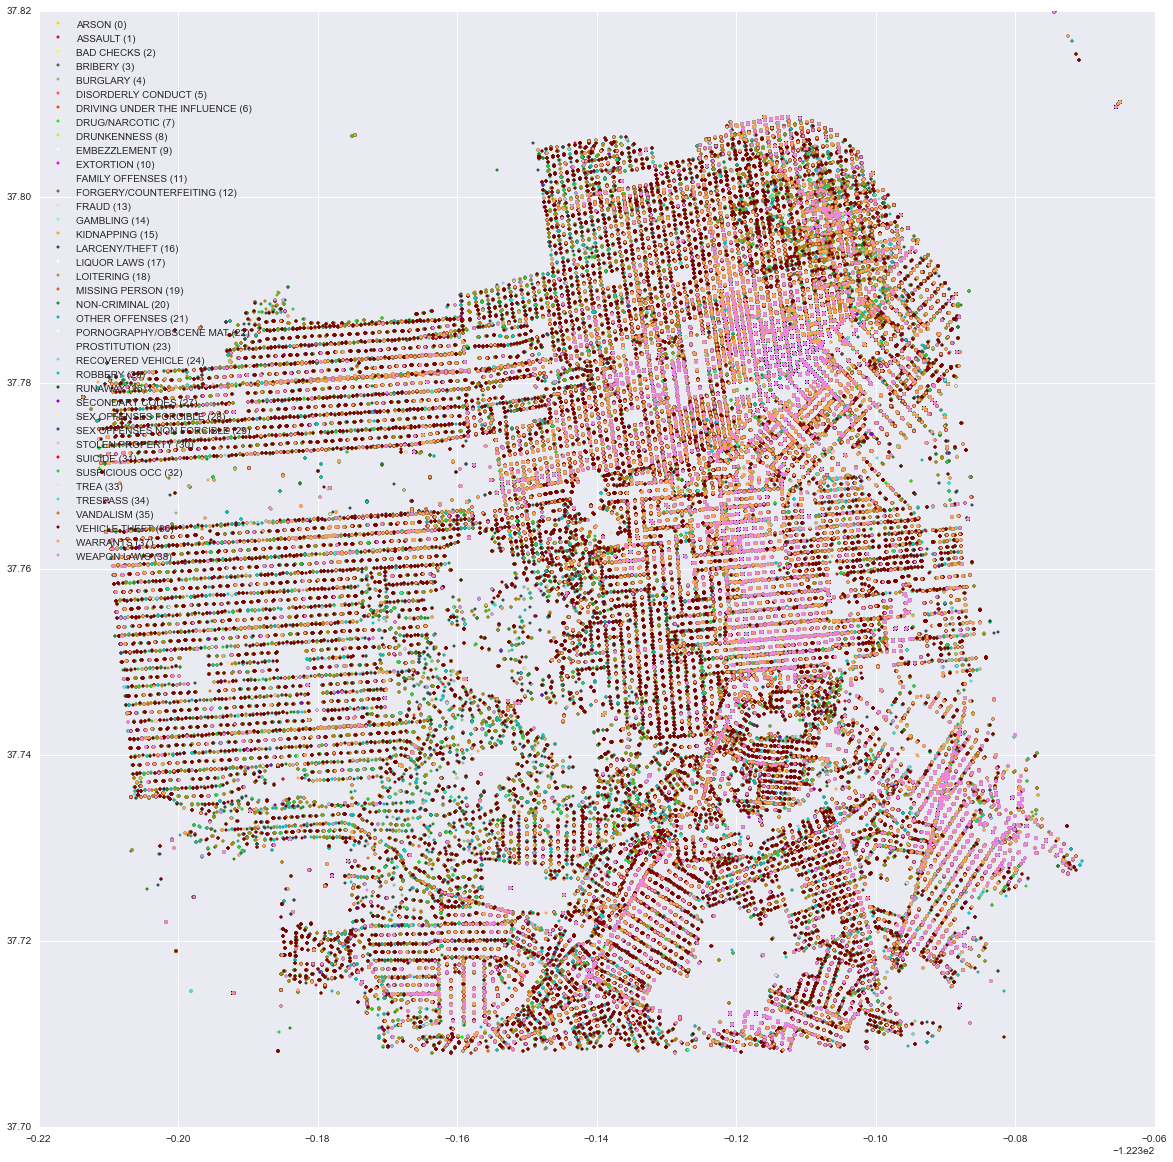

In [18]:
def plot_crime(narrow_area):
    crimes = train_df_new.crime.unique()
    idx = []
    for i in range(len(crimes)):
        df = narrow_area[narrow_area.crime == i]
        if df.shape[0] > 0:
            idx.append(i)
            plt.plot(df.X, df.Y, 'o', markerfacecolor=col[i*2+1],markeredgecolor='black',markersize=3)
    plt.legend(["{} ({})".format(cat_orig[idx[i]],idx[i]) for i in range(len(idx))], 'upper left')

fig = plt.figure(figsize=(20,20))
narrow_area = train_df_new[(train_df_new.X < -122)]
plot_crime(narrow_area)

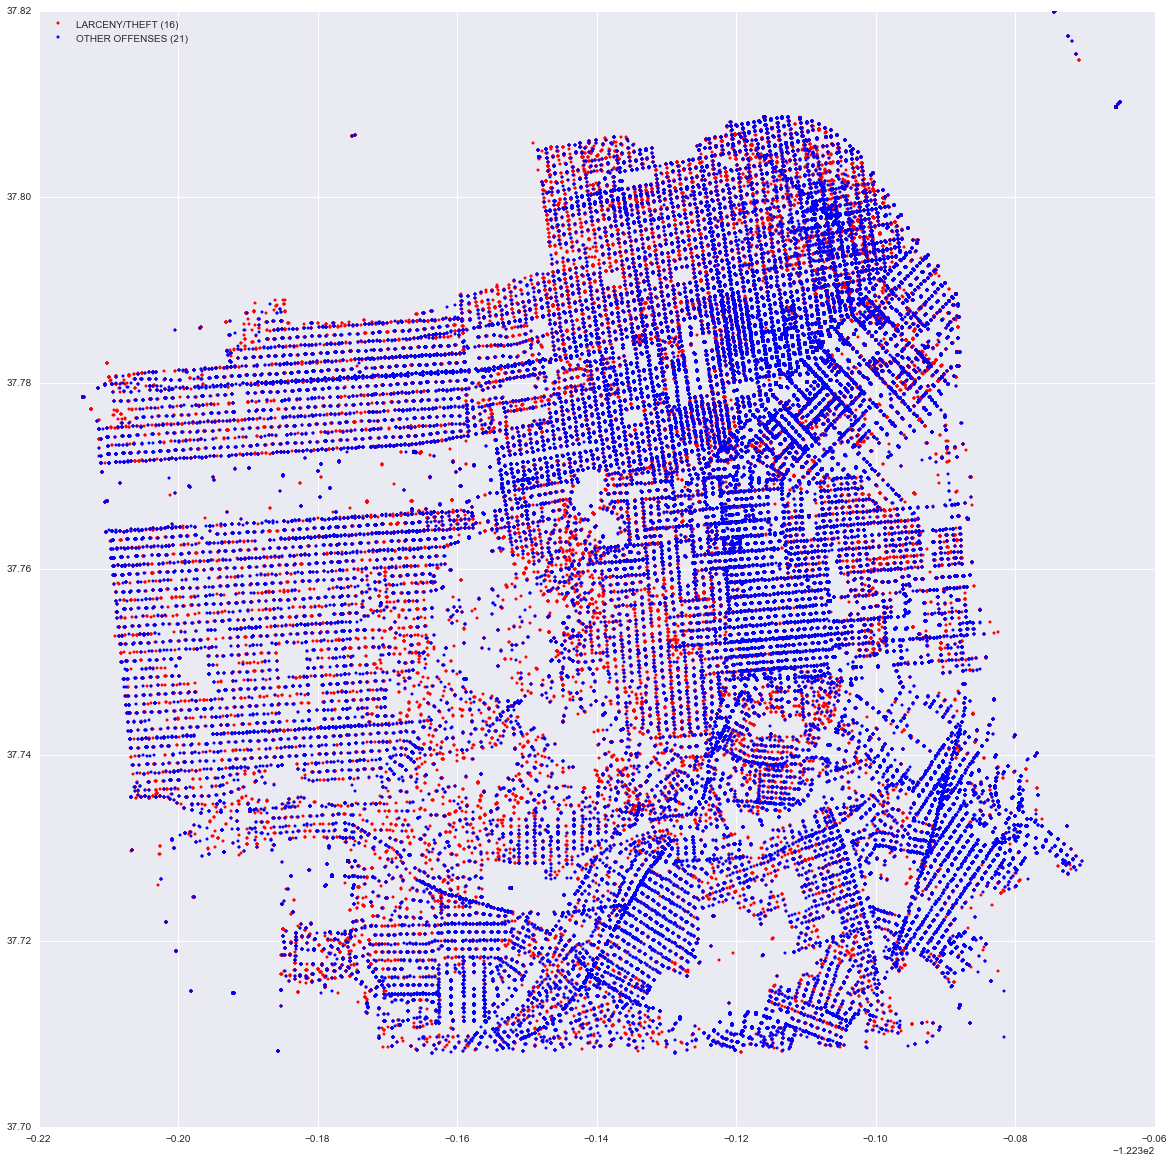

In [23]:
fig = plt.figure(figsize=(20,20))
narrow_area = train_df_new[(train_df_new.X < -122)]
idx = []
top_crimes = [16,21]
crime_col = ['red','blue']
for i in range(len(top_crimes)):
    df = narrow_area[narrow_area.crime == top_crimes[i]]
    if df.shape[0] > 0:
        idx.append(top_crimes[i])
        plt.plot(df.X, df.Y, 'o', markerfacecolor=crime_col[i],markeredgecolor='black',markersize=3)
plt.legend(["{} ({})".format(cat_orig[idx[i]],idx[i]) for i in range(len(idx))], 'upper left')

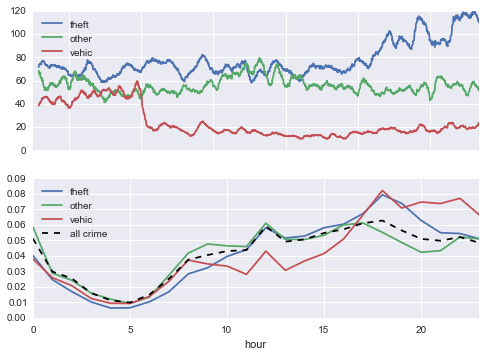

In [59]:
plt.subplot(2,1,1)
theft = narrow_area[narrow_area.crime == 16]
other = narrow_area[narrow_area.crime == 21]
vehic = narrow_area[narrow_area.crime == 36]
theft_by_date = theft.groupby('date').count().crime
other_by_date = other.groupby('date').count().crime
vehic_by_date = vehic.groupby('date').count().crime

pd.rolling_mean(theft_by_date,30).plot()
pd.rolling_mean(other_by_date,30).plot()
pd.rolling_mean(vehic_by_date,30).plot()

plt.legend(['theft','other','vehic'],'upper left')

plt.subplot(2,1,2)
theft_by_hour = theft.groupby(['hour']).count().crime
other_by_hour = other.groupby(['hour']).count().crime
vehic_by_hour = vehic.groupby(['hour']).count().crime
theft_by_hour_norm = theft_by_hour / float(theft_by_hour.sum())
other_by_hour_norm = other_by_hour / float(other_by_hour.sum())
vehic_by_hour_norm = vehic_by_hour / float(vehic_by_hour.sum())
theft_by_hour_norm.plot()
other_by_hour_norm.plot()
vehic_by_hour_norm.plot()
all_crime_by_hour = narrow_area.groupby(['hour']).count().crime
all_crime_by_hour_norm = all_crime_by_hour / float(all_crime_by_hour.sum())
all_crime_by_hour_norm.plot(ls='dashed',color='black')

plt.legend(['theft','other','vehic','all crime'],'upper left')

In [62]:
# Split this into Dev and Training Data
DEV_SIZE = 0.20

# fix a random seed
np.random.seed(0)
# Create boolean mask
# np.random creates a vector of random values between 0 and 1
# Those values are filtered to create a binary mask
msk = np.random.rand(len(train_df_new)) < DEV_SIZE

dev = train_df_new[msk]
dev_labels = np.array(dev.crime)
dev.drop('crime',1,inplace=True)

train = train_df_new[~msk]  # inverse of boolean mask
train_labels = np.array(train.crime)
train.drop('crime',1,inplace=True)

print "Dev: " + str(dev.shape)
print "Train: " + str(train.shape)
#print "Test: " + str(test_df.shape)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Dev: (175399, 9)
Train: (702650, 9)


/usr/local/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


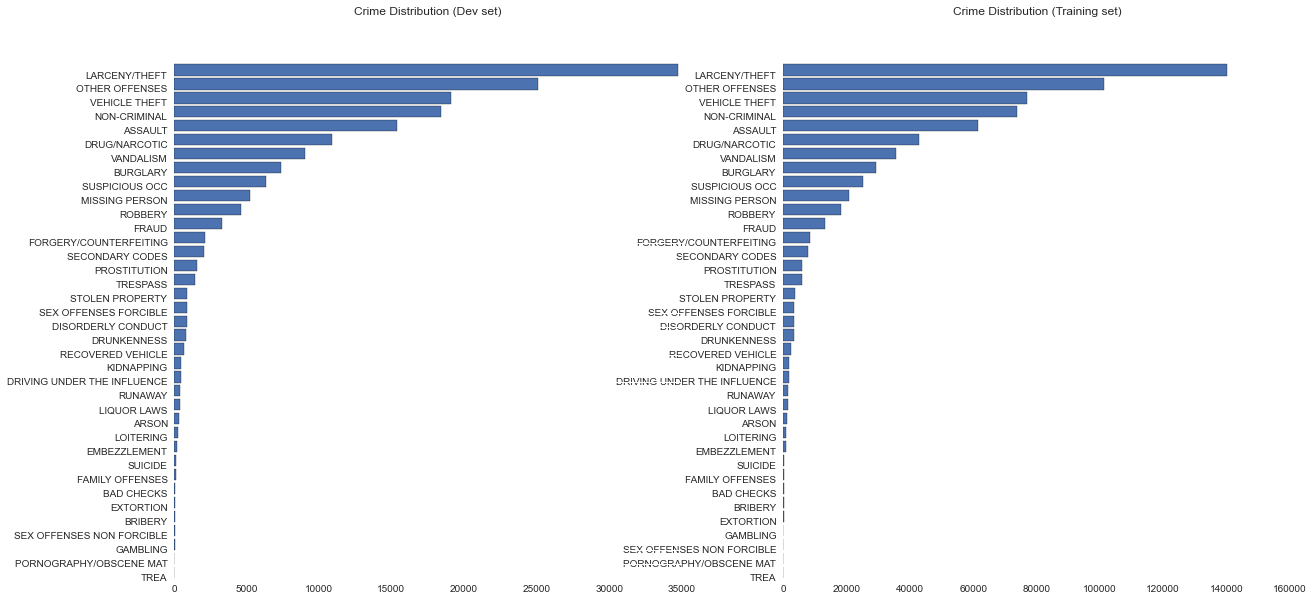

In [63]:
# make sure dev and train datasets have similar
# distribution for outcome variable
plt.figure(figsize=(20,10))
labels = [train_labels, dev_labels]
titles = ["Training set","Dev set"]
for i in [0,1]:
    plt.subplot(1,2,i)
    hist = np.histogram(labels[i], bins=range(38))
    ix = np.argsort(hist[0])
    plt.barh(range(37),hist[0][ix])
    x = plt.yticks(range(37),cat_orig[ix])
    ttl = "Crime Distribution ({})".format(titles[i])
    plt.title(ttl)

In [64]:
# convert training set to np array
train_data = np.array(train[['dow','pd','hour','minutes','X','Y']])
dev_data = np.array(dev[['dow','pd','hour','minutes','X','Y']])

model = RFC()
model.fit(train_data,train_labels)

preds = model.predict(dev_data)

In [65]:
accuracy = metrics.accuracy_score(dev_labels,preds)
print accuracy

0.26930598236


In [324]:
train.head()

,date,hour,dow,pd,addr,X,Y
0,2015-05-13,23,6,4,19790,-122.425892,37.774599
1,2015-05-13,23,6,4,19790,-122.425892,37.774599
2,2015-05-13,23,6,4,22697,-122.424363,37.800414
3,2015-05-13,23,6,4,4266,-122.426995,37.800873
4,2015-05-13,23,6,5,1843,-122.438738,37.771541


In [16]:
labels = ['Id']
for i in model.classes_:
    labels.append(i)

with open('GaussianNB.csv', 'wb') as csvfile:
    fo = csv.writer(csvfile, lineterminator='\n')
    fo.writerow(labels)

    for i, pred in enumerate(predicted):
        fo.writerow([i] + list(pred))

In [195]:
model = GaussianNB()
model.fit(train,train_labels)

predicted = np.array(model.predict_proba(dev))

ValueError: invalid literal for float(): 2003-01-06 00:01:00

In [35]:
#working with a smaller sample for ease of manipulation
#created train_350.csv which only has 350 records

train_sm = pd.read_csv('Data\\train_350.csv')
temp = pd.DatetimeIndex(train_sm['Dates'])
train_sm['Date'] = temp.date
train_sm['Time'] = temp.time
train_sm['Hour'] = temp.hour
del train_sm['Dates']

# Feature Names: address, dayofweek
le = preprocessing.LabelEncoder()
le.fit(np.unique(train_sm.DayOfWeek.values))
train_sm.DayOfWeek = le.transform(train_sm.DayOfWeek)

le.fit(np.unique(train_sm.Address.values))
train_sm.Address = le.transform(train_sm.Address)

print train_sm

            Category                                           Descript  \
0           WARRANTS                                     WARRANT ARREST   
1     OTHER OFFENSES                           TRAFFIC VIOLATION ARREST   
2     OTHER OFFENSES                           TRAFFIC VIOLATION ARREST   
3      LARCENY/THEFT                       GRAND THEFT FROM LOCKED AUTO   
4      LARCENY/THEFT                       GRAND THEFT FROM LOCKED AUTO   
5      LARCENY/THEFT                     GRAND THEFT FROM UNLOCKED AUTO   
6      VEHICLE THEFT                                  STOLEN AUTOMOBILE   
7      VEHICLE THEFT                                  STOLEN AUTOMOBILE   
8      LARCENY/THEFT                       GRAND THEFT FROM LOCKED AUTO   
9      LARCENY/THEFT                       GRAND THEFT FROM LOCKED AUTO   
10     LARCENY/THEFT                       PETTY THEFT FROM LOCKED AUTO   
11    OTHER OFFENSES                        MISCELLANEOUS INVESTIGATION   
12         VANDALISM     

In [36]:
dummy_cat = pd.get_dummies(train_sm['Category'], prefix='c')
dummy_dist = pd.get_dummies(train_sm['PdDistrict'], prefix='d')
print dummy_dist

     d_BAYVIEW  d_CENTRAL  d_INGLESIDE  d_MISSION  d_NORTHERN  d_PARK  \
0            0          0            0          0           1       0   
1            0          0            0          0           1       0   
2            0          0            0          0           1       0   
3            0          0            0          0           1       0   
4            0          0            0          0           0       1   
5            0          0            1          0           0       0   
6            0          0            1          0           0       0   
7            1          0            0          0           0       0   
8            0          0            0          0           0       0   
9            0          1            0          0           0       0   
10           0          1            0          0           0       0   
11           0          0            0          0           0       0   
12           0          0            0          0  

In [37]:
train_smd = pd.concat([train_sm, dummy_cat, dummy_dist], axis=1)
del train_smd['Category']
del train_smd['Descript']
del train_smd['Resolution']
del train_smd['PdDistrict']
print train_smd

     DayOfWeek  Address           X          Y        Date      Time  Hour  \
0            0      248 -122.425892  37.774599  2015-05-13  23:53:00    23   
1            0      248 -122.425892  37.774599  2015-05-13  23:53:00    23   
2            0      265 -122.424363  37.800414  2015-05-13  23:33:00    23   
3            0       67 -122.426995  37.800873  2015-05-13  23:30:00    23   
4            0       28 -122.438738  37.771541  2015-05-13  23:30:00    23   
5            0       22 -122.403252  37.713431  2015-05-13  23:30:00    23   
6            0      199 -122.423327  37.725138  2015-05-13  23:30:00    23   
7            0      238 -122.371274  37.727564  2015-05-13  23:30:00    23   
8            0      168 -122.508194  37.776601  2015-05-13  23:00:00    23   
9            0      234 -122.419088  37.807802  2015-05-13  23:00:00    23   
10           0      234 -122.419088  37.807802  2015-05-13  22:58:00    22   
11           0        9 -122.487983  37.737667  2015-05-13  22:3